### Problem 1: Projectile Motion with Air Resistance
In this problem, you will write a function to calculate the trajectory of a baseball with and without air resistance. The radius of the baseball is $r = 0.0366$ m, and $A = \pi r^2$. The mass is $m = 0.145$ kg, the drag coefficient is $C_d = 0.5$ (appropriate for a batted ball or pitched fastball), and the density of air is $\rho = 1.16$ kg/m$^3$ (appropriate for PNC Park at an elevation of 225 m).

a. Using the force from drag in turbulent flow, write down the system of four first-order ODEs (for dependent variables $x$, $y$, $v_x$, and $v_y$).

b. Integrate the equations using `scipy.integrate.odeint`.  (`odeint` default to using a `lsoda` integrator which is a good generaly-purpose choice).  Run the simulation log enough for the baseball to reach the ground (the same height that it started at).
  * Calculate the trajectory of the baseball when the ball is given an initial velocity of $50$ m/s at an angle of $35^\circ$ above the $+x$-axis.
  * Plot the result with and without air resistance on the same plot.  
Physical intuition should tell you that both the range of the baseball and the maximum height reached with drag should be substantially less than the zero-drag calculation predicts.  Does the plotted data agree with this?

------

Let b = $\frac{1}{2m}\rho C_d A $ The system of four first-order ODEs is as follows:

$\frac{dy}{dt} = v_y$

$\frac{dv_y}{dt} = -g - bv^2 \frac{{|v_y|}}{v} = -g -b|v|v_y$

$\frac{dx}{dt} = v_x$

$\frac{dv_x}{dt} = -bv^2 \frac{{|v_x|}}{v} = -b|v|v_x$

where $|v| = \sqrt{v_x^2 + v_y^2}$

I used the Verlet method for this problem.

Max Height Drag: 25.9182875802
Max Height No Drag: 41.9629699825
Max Range Drag: 135.515681532
Max Range No Drag: 286.703215501


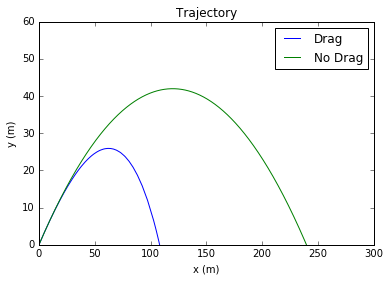

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint


def verlet_step(func, y, t, dt, i):
    y[i+2, :] = y[i  , :] + 2*dt * func(y[i+1,:], t[i+1])
    y[i+3, :] = y[i+1, :] + 2*dt * func(y[i+2,:], t[i+2])
    
    return y

def verlet(func, r, t):
    
    num_variables = len(r)
    y = np.zeros((len(t), num_variables))
    y[0,:] = r

    dt = t[1] - t[0]
    
    # initialize
    y[1,:] = y[0,:] + dt * func(y[0,:], t[0]) #y1 = y0 + dt*dydt

    for i in range(0, len(t)-3):
        y = verlet_step(func, y, t, dt, i)
        
    return y

C_d = 0.5
rho = 1.16
m = 0.145
r = 0.0366
g = 9.8
A = np.pi*0.0366**2

b= 1/(2*m) * rho * A * C_d

def y_acceleration(v_x, v_y):
    return -g - b * np.sqrt(v_x**2 + v_y**2) * v_y

def x_acceleration(v_x, v_y):
    return -b * np.sqrt(v_x**2 + v_y**2) * v_x

def F(r, t):
    v_x, v_y = r[2], r[3]
    a_x, a_y = x_acceleration(v_x, v_y), y_acceleration(v_x, v_y)
    return np.array([v_x, v_y, a_x, a_y])


T = np.linspace(0,7, 1000)
r = np.array([0, 0, 50*np.cos(35*np.pi/180), 50*np.sin(35*np.pi/180)])

data = verlet(F, r, T)
X1, Y1, VX1, VY1 = data[:,0], data[:, 1], data[:,2], data[:,3]

plt.plot(X1, Y1, label='Drag')
plt.title('Trajectory')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

b = 0

data = odeint(F, r, T)
X2, Y2, VX2, VY2 = data[:,0], data[:, 1], data[:,2], data[:,3]

plt.plot(X2, Y2, label='No Drag')
plt.legend(loc='best')
plt.ylim(0,60)

print('Max Height Drag:', max(Y1))
print('Max Height No Drag:', max(Y2))
print('Max Range Drag:', max(X1))
print('Max Range No Drag:', max(X2))

The plot shows that the max height and max range is greater when no drag is present.

### Problem 2: Simple Orbital Motion
Solve the simplest problem of celestial mechanics: a small
mass $m$ (such as the Earth) moving in a central gravitational potential $M/r$ (such as the Sun's).

a. Write down the system of 4 first order ODEs (two planar coordinates, plus two velocities) that you will have to solve.
  * Use Cartesian coordinates $x$ and $y$ in the orbital plane, and center the potential on $(x, y) = (0, 0)$.
  * Derive the ODEs from Newton's Law of Universal Gravitation without constraining the motion to be circular.

b. Choose initial conditions that represent a circular orbit  
(Hint: set the initial radius $R$ and velocity $v$ so that the centripetal acceleration $v^2/R$ equals the gravitational force $1/R^2$).
  * For the simple case of $M = G = 1$, plot the current location of the mass with a large circle and the resulting orbit as a series of points by integrating with `scipy.integrate.odeint`.
  * Check that your simulation is stable for your chosen time step by integrating for a long time.
  * Clearly indicate your initial conditions, the time step you used, and the plot.

------

a.

I used $-\frac{dU}{dx} = F(x) = ma$ to derive ODEs with velocities. Gravitational potential energy can be written as $U_g = -\frac{GMm}{\sqrt{x^2 + y^2}}$ where $r^2 = x^2 + y^2$.

$\frac{dy}{dt} = v_y$

$\frac{dv_y}{dt} = -\frac{1}{m}\frac{\partial U_g}{\partial x} = -\frac{GMx}{(x^2 + y^2)^{3/2}}$

$\frac{dx}{dt} = v_x$

$\frac{dv_x}{dt} = -\frac{1}{m}\frac{\partial U_g}{\partial y} = -\frac{GMy}{(x^2 + y^2)^{3/2}}$

b.

For a circular orbit, $\frac{mv^2}{r} = \frac{GMm}{r^2}$, so with $G = M = 1$

$$v = \sqrt{\frac{GM}{r}} = \frac{\sqrt{GM}}{(x^2 + y^2)^{1/4}} = \frac{1}{(x^2 + y^2)^{1/4}}$$

Any initial conditions that satisfy the above equation will result in a circular orbit. Let's choose some initial conditions

$$x(0) = 0$$ 
$$y(0) = 9$$ 
$$v(0, 0) = \frac{1}{3}$$

Since we need $v_x$ and $v_y$, we can pick any combination so long as it satisfies 
$\sqrt{v_x^2 + v_y^2} = \frac{1}{3} = v(0, 0)$. The simplest option would be

$$v_x(0, 0) = \frac{1}{3}$$
$$v_y(0, 0) = 0$$


TIME STEP: dt = 5.05050505051


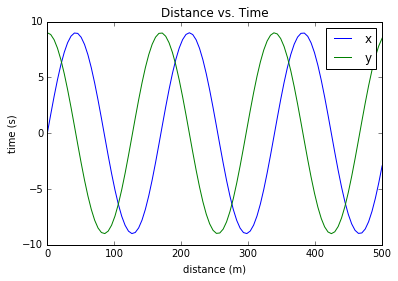

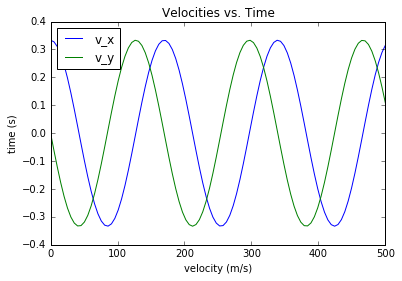

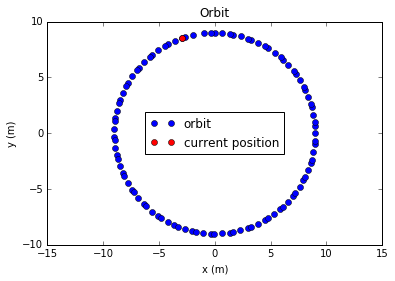

In [6]:
# @TODO: Write leapfrog or Verlet method and use it on a homework problem. Calculate energy too.
def leapfrog_step(func, y, t, dt):
    pass

def rk4_step(func, y, t, dt):
    k1 = dt * func(y, t)
    k2 = dt * func(y + k1/2, t + dt/2)
    k3 = dt * func(y + k2/2, t + dt/2)
    k4 = dt * func(y + k3,   t + dt)
    y += (1/6) * (k1 + 2*k2 +2*k3 + k4)
    return y

def leapfrog(func, y0, t):
    num_variables = len(y0)
    y = np.zeros((len(t), num_variables))
    y[0,:] = y0
    
    dt = t[1] - t[0]
    
    y[1,:] = y[0,:] + dt*func(y[0,:], t[0])
    
    for i in range(0, len(t)-3,2):
        dt = t[i+1] - t[i]
        y[i+2,:] =y[i  , :] + 2*dt + func(y[i+1,:], t[i+1])
        y[i+3,:] =y[i+1, :] + 2*dt + func(y[i+2,:], t[2+1])
        
    y[-1,:] = y[-3,:] + 2*dt + func(y[i-2,:], t[i-2])
    
    return y












def x_acceleration1(x, y, G=1, M=1):
    return -G*M*x/(x**2 + y**2)**(3/2)

def y_acceleration1(x, y, G=1, M=1):
    return -G*M*y/(x**2 + y**2)**(3/2)

def x_acceleration1(x, y, G=1, M=1):
    return -G*M*x/(x**2 + y**2)**(3/2)

def y_acceleration1(x, y, G=1, M=1):
    return -G*M*y/(x**2 + y**2)**(3/2)

def G(r, t):
    x, y, v_x, v_y = r[0], r[1], r[2], r[3]
    a_x, a_y = x_acceleration1(x, y), y_acceleration1(x, y)
    return np.array([v_x, v_y, a_x, a_y])

def plot3():
    T = np.linspace(0,500, 100)
    r1 = np.array([0, 9, 1/3, 0])

    data = odeint(G, r1, T)
    X, Y, VX, VY = data[:,0], data[:, 1], data[:,2], data[:,3]
    
    print('TIME STEP: dt =', T[1] - T[0])

    plt.plot(T,X, label='x')
    plt.plot(T,Y, label='y')
    plt.title('Distance vs. Time')
    plt.xlabel('distance (m)')
    plt.ylabel('time (s)')
    plt.legend(loc='best')
    plt.show()

    plt.plot(T, VX, label='v_x')
    plt.plot(T, VY, label='v_y')
    plt.title('Velocities vs. Time')
    plt.xlabel('velocity (m/s)')
    plt.ylabel('time (s)')
    plt.legend(loc='best')
    plt.show()

    plt.plot(X, Y, 'bo', label='orbit')
    plt.plot(X[-1], Y[-1], 'ro', label='current position')
    plt.title('Orbit')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend(loc='best')
    plt.axis('equal')
    plt.show()
    
plot3()

### Problem 3: Ternary Star System
Solve for the orbits in a triple star system.  More generically consider the case of three comparable masses in a plane. You will have to evolve a total of twelve dynamical variables (three times two planar coordinates, plus three times two velocities). Verify the simplest Lagrange solution[1], where three equal masses $M_1 = M_2 = M_3 = M$ move along the vertices of a rotating, equilateral triangle. In this solution the side $d$ of the triangle and the velocity $v$ of the masses are related by $v = \sqrt{GM/d}$.

[1] which is related to the L4 and L5 Lagrange points explored in Problem 5.

a. Write down the system of 12 first order ODEs (three times two planar coordinates, plus three times two velocities) that you will have to solve. Derive the ODEs from Newton's Law of Universal Gravitation for three bodies without constraining the motion to be circular.

b. For the simple case of $M = G = d = 1$, plot the resulting orbits along with the velocity phase space.  Integrating using `scipy.integrate.odeint` over several orbital periods, with different color for each star.
  * Start with an appropriate initial condition to give the simplest Lagrange solution.
  * Include the time step you used.  
  * Also make plots for two other values of the magnitude of the starting velocities to show the different shaped orbits you can get.

------


$U_G = -\frac{GM_1M_2}{\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}} 
       -\frac{GM_1M_3}{\sqrt{(x_1 - x_3)^2 + (y_1 - y_3)^2}}
       -\frac{GM_2M_3}{\sqrt{(x_2 - x_3)^2 + (y_2 - y_3)^2}}$

For $M_1$

$\frac{dy_1}{dt} = v_{1y}$

$\frac{dx_1}{dt} = v_{1x}$

$\frac{dv_{y_1}}{dt} = 
-\frac{GM_2}{\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}}(y_1 - y_2)
-\frac{GM_3}{\sqrt{(x_1 - x_3)^2 + (y_1 - y_3)^2}}(y_1 - y_3)$

$\frac{dv_{x_1}}{dt} = 
-\frac{GM_2}{\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}}(x_1 - x_2)
-\frac{GM_3}{\sqrt{(x_1 - x_3)^2 + (y_1 - y_3)^2}}(x_1 - x_3)$

For $M_2$

$\frac{dy_2}{dt} = v_{2y}$

$\frac{dx_2}{dt} = v_{2x}$

$\frac{dv_{y_2}}{dt} =
-\frac{GM_1}{\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}}(y_1 - y_2)
-\frac{GM_3}{\sqrt{(x_2 - x_3)^2 + (y_2 - y_3)^2}}(y_2 - y_3)$

$\frac{dv_{x_2}}{dt} =
-\frac{GM_1}{\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}}(x_1 - x_2)
-\frac{GM_3}{\sqrt{(x_2 - x_3)^2 + (y_2 - y_3)^2}}(x_2 - x_3)$

For $M_3$

$\frac{dy_3}{dt} = v_{3y}$

$\frac{dx_3}{dt} = v_{3x}$

$\frac{dv_{y_3}}{dt} =
-\frac{GM_1}{\sqrt{(x_1 - x_3)^2 + (y_1 - y_3)^2}}(y_1 - y_3)
-\frac{GM_2}{\sqrt{(x_2 - x_3)^2 + (y_2 - y_3)^2}}(y_2 - y_3)$

$\frac{dv_{x_3}}{dt} =
-\frac{GM_1}{\sqrt{(x_1 - x_3)^2 + (y_1 - y_3)^2}}(x_1 - x_3)
-\frac{GM_2}{\sqrt{(x_2 - x_3)^2 + (y_2 - y_3)^2}}(x_2 - x_3)$

Initial conditions...

The masses must be at verticies of an equilateral triangle. This is one such arrangement (looks like the Mercedes-Benz logo). Note that the distance from a vertex of the equilateral triangle to the center will be $\frac{d}{\sqrt{3}}$. 
(That's the radius of an inscribed circle). Let $L = \frac{d}{\sqrt{3}}$.

$(x_1, y_1) = (0, L)$ 

$(x_2, y_2) = (L\cos \frac{7\pi}{6}, L\sin \frac{7\pi}{6}) = (-L\frac{\sqrt{3}}{2}, -L\frac{1}{2})$

$(x_2, y_2) = (L\cos \frac{-\pi}{6}, L\sin \frac{-\pi}{6}) = (L\frac{\sqrt{3}}{2}, L\frac{1}{2})$

The initial velocities must satisfy $v = \sqrt{\frac{GM}{d}} = 1$ for $G = M = d = 1$. I imagined the stars moving counterclockwise and just kind of went from there.

$(v_{1x}, v_{1y}) = (-1, 0)$

$(v_{2x}, v_{2y}) = (-\frac{1}{2}, \frac{\sqrt{3}}{2})$

$(v_{3x}, v_{3y}) = ( \frac{1}{2}, \frac{\sqrt{3}}{2})$

Velocity magnitude: 1
TIME STEP: dt = 0.01
TIME PASSED: 10


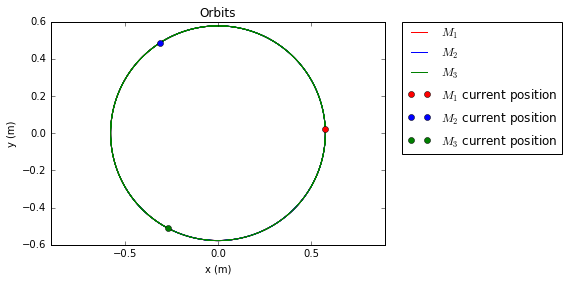

Velocity magnitude: 2/3
TIME STEP: dt = 0.01
TIME PASSED: 10


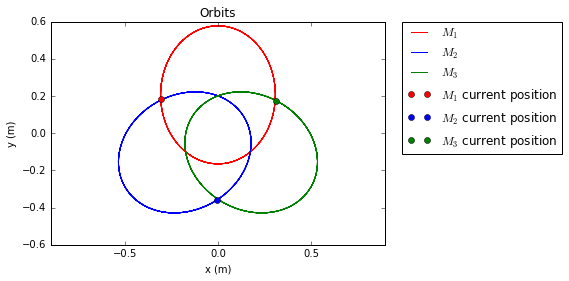

Velocity magnitude: 1.1
TIME STEP: dt = 0.01
TIME PASSED: 10


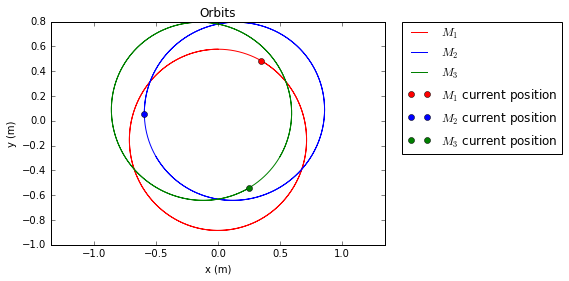

Velocity magnitude: 1.6
TIME STEP: dt = 0.01
TIME PASSED: 10


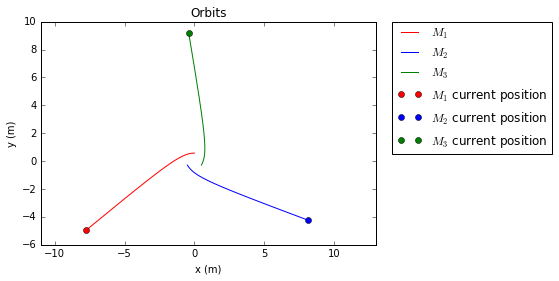

In [7]:
M_1 = 1
M_2 = 1
M_3 = 1

# I really could've written two functions instead of six, but I chose to write out six so that I wouldn't confuse 
# myself. I could actually write one function to describe all of the accelerations (notice how all of the functions
# are analogous i.e. have the same form). It's just harder to keep track of variables that way.
def acc_1x(x1, x2, x3, y1, y2, y3):
    r12 = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    r13 = np.sqrt((x1-x3)**2 + (y1-y3)**2)
    return -M_2/r12**3 * (x1-x2) - M_3/r13**3 * (x1-x3)

def acc_2x(x1, x2, x3, y1, y2, y3):
    r23 = np.sqrt((x2-x3)**2 + (y2-y3)**2)
    r21 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    return -M_3/r23**3 * (x2-x3) - M_1/r21**3 * (x2-x1)

def acc_3x(x1, x2, x3, y1, y2, y3):
    r31 = np.sqrt((x3-x1)**2 + (y3-y1)**2)
    r32 = np.sqrt((x3-x2)**2 + (y3-y2)**2)
    return -M_1/r31**3 * (x3-x1) - M_2/r32**3 * (x3-x2)

def acc_1y(x1, x2, x3, y1, y2, y3):
    r12 = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    r13 = np.sqrt((x1-x3)**2 + (y1-y3)**2)
    return -M_2/r12**3 * (y1-y2) - M_3/r13**3 * (y1-y3)

def acc_2y(x1, x2, x3, y1, y2, y3):
    r23 = np.sqrt((x2-x3)**2 + (y2-y3)**2)
    r21 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    return -M_3/r23**3 * (y2-y3) - M_1/r21**3 * (y2-y1)

def acc_3y(x1, x2, x3, y1, y2, y3):
    r31 = np.sqrt((x3-x1)**2 + (y3-y1)**2)
    r32 = np.sqrt((x3-x2)**2 + (y3-y2)**2)
    return -M_1/r31**3 * (y3-y1) - M_2/r32**3 * (y3-y2)

def F4(r, t):
    x1, y1, v_1x, v_1y = r[0], r[1], r[2], r[3]
    x2, y2, v_2x, v_2y = r[4], r[5], r[6], r[7]
    x3, y3, v_3x, v_3y = r[8], r[9], r[10], r[11]
    
    a_1x, a_1y = acc_1x(x1, x2, x3, y1, y2, y3), acc_1y(x1, x2, x3, y1, y2, y3)
    a_2x, a_2y = acc_2x(x1, x2, x3, y1, y2, y3), acc_2y(x1, x2, x3, y1, y2, y3)
    a_3x, a_3y = acc_3x(x1, x2, x3, y1, y2, y3), acc_3y(x1, x2, x3, y1, y2, y3)
    
    return np.array( [v_1x, v_1y, a_1x, a_1y,
                      v_2x, v_2y, a_2x, a_2y,
                      v_3x, v_3y, a_3x, a_3y])


def plot4(r, max_time, debug=False):
    T = np.linspace(0, max_time, max_time*100 + 1)

    data = odeint(F4, r, T)
    X1, Y1, V1x, V1y = data[:,0], data[:,1], data[:,2], data[:,3]
    X2, Y2, V2x, V2y = data[:,4], data[:,5], data[:,6], data[:,7]
    X3, Y3, V3x, V3y = data[:,8], data[:,9], data[:,10], data[:,11]
    
    print('TIME STEP: dt =', T[1] - T[0])
    print('TIME PASSED:', max_time)
    
    if debug:
        # Initial positions
        plt.plot(r2[0], r2[1], 'ro', label='$M_1$')
        plt.plot(r2[4], r2[5], 'bo', label='$M_2$')
        plt.plot(r2[8], r2[9], 'go', label='$M_3$')
        plt.plot(0, 0, 'yo', label='origin')
        plt.title('Initial Positions')
        plt.ylabel('y (m)')
        plt.xlabel('x (m)')
        plt.axis('equal')
        plt.legend(loc='best')
        plt.show()

    plt.plot(X1, Y1, 'r', label='$M_1$')
    plt.plot(X2, Y2, 'b', label='$M_2$')
    plt.plot(X3, Y3, 'g', label='$M_3$')
    plt.plot(X1[-1], Y1[-1], 'ro', label='$M_1$ current position')
    plt.plot(X2[-1], Y2[-1], 'bo', label='$M_2$ current position')
    plt.plot(X3[-1], Y3[-1], 'go', label='$M_3$ current position')
    plt.title('Orbits')
    plt.ylabel('y (m)')
    plt.xlabel('x (m)')
    plt.axis('equal')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

def run_plot4():
    L = 1/np.sqrt(3)

    x1, x2, x3 = 0, -L*np.sqrt(3)/2, L*np.sqrt(3)/2
    y1, y2, y3 = L, -L/2, -L/2
    v1x, v2x, v3x = -1, 1/2, 1/2
    v1y, v2y, v3y = 0, -np.sqrt(3)/2, np.sqrt(3)/2

    # circular orbits
    r2 = np.array([x1, y1, v1x, v1y,
                   x2, y2, v2x, v2y,
                   x3, y3, v3x, v3y])

    r2_1 = np.array([x1, y1, v1x*2/3, v1y*2/3,
                     x2, y2, v2x*2/3, v2y*2/3,
                     x3, y3, v3x*2/3, v3y*2/3])

    r2_2 = np.array([x1, y1, v1x*1.1, v1y*1.1,
                     x2, y2, v2x*1.1, v2y*1.1,
                     x3, y3, v3x*1.1, v3y*1.1])

    r2_3 = np.array([x1, y1, v1x*1.6, v1y*1.6,
                     x2, y2, v2x*1.6, v2y*1.6,
                     x3, y3, v3x*1.6, v3y*1.6])

    print('Velocity magnitude: 1')
    plot4(r2, 10)
    print('Velocity magnitude: 2/3')
    plot4(r2_1, 10)
    print('Velocity magnitude: 1.1')
    plot4(r2_2, 10)
    print('Velocity magnitude: 1.6')
    plot4(r2_3, 10)
    
run_plot4()

### Problem 4: Choreographic Orbits
Simulate the fascinating choreographic orbit describing the motion of three equal-mass bodies along a "figure 8" ($\infty$). For motion contained in the $x$-$y$ plane and units where $G = M_1 = M_2 = M_3 = 1$, approximate initial conditions are:
\begin{align*}
(x_3, y_3) &= (0, 0) & (v_{x3}, v_{y3}) &= (-0.93240737, -0.86473146)\\
(x_1, y_1) &= (0.97000436, -0.24308753) & (v_{x1}, v_{y1}) &= (-v_{x3}/2, -v_{y3}/2)\\
(x_2, y_2) &= (-x_1,-y_1) & (v_{x2}, v_{y2}) &= (-v_{x3}/2, -v_{y3}/2)
\end{align*}
(and $z_1 = z_2 = z_3 = 0$ at all times).

* Plot the resulting orbits from integrating with `scipy.integrate.odeint` over several orbital periods, with different color points for each mass.
* Include the time step you used and plot the orbits.
* Explore and describe how sensitive this elegant dance of masses is to the initial conditions.

------

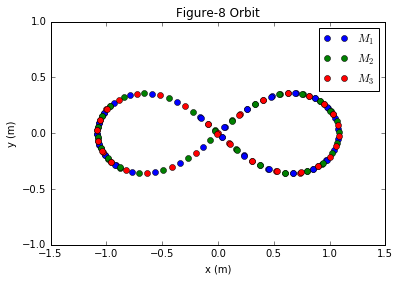

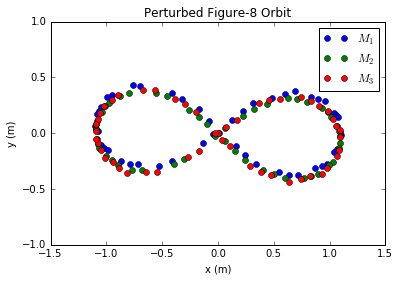

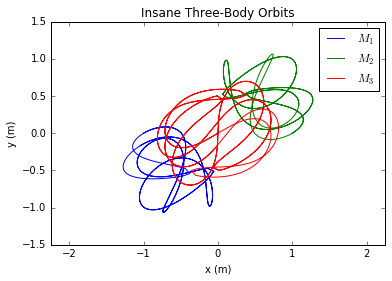

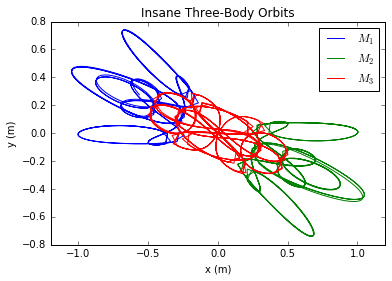

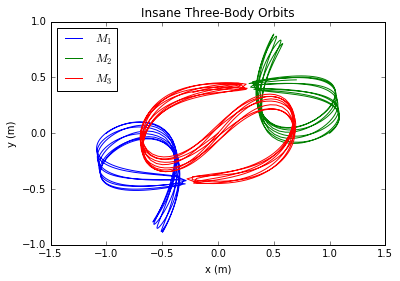

In [8]:
def plot5():
    T = np.linspace(0,100, 50)
    
    x1, y1 = 0.97000436, -0.24308753
    vx3, vy3 = -0.93240737, -0.86473146
    
    r3 = np.array([ x1,  y1, -vx3/2, -vy3/2,
                   -x1, -y1, -vx3/2, -vy3/2,
                     0,   0,    vx3,    vy3 ])


    data = odeint(F4, r3, T)
    X1, Y1, V1x, V1y = data[:,0], data[:,1], data[:,2], data[:,3]
    X2, Y2, V2x, V2y = data[:,4], data[:,5], data[:,6], data[:,7]
    X3, Y3, V3x, V3y = data[:,8], data[:,9], data[:,10], data[:,11]

    
    plt.plot(X1, Y1, 'bo', label='$M_1$')
    plt.plot(X2, Y2, 'go', label='$M_2$')
    plt.plot(X3, Y3, 'ro', label='$M_3$')
    plt.legend(loc='best')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('Figure-8 Orbit')
    plt.axis('equal')
    plt.show()
    
    x1, y1 = 0.98000436, -0.27308753
    vx3, vy3 = -0.95240737, -0.82473146
    
    r4 = np.array([ x1,  y1, -vx3/2, -vy3/2,
                   -x1, -y1, -vx3/2, -vy3/2,
                     0,   0,    vx3,    vy3 ])    

    data = odeint(F4, r4, T)
    X1, Y1, V1x, V1y = data[:,0], data[:,1], data[:,2], data[:,3]
    X2, Y2, V2x, V2y = data[:,4], data[:,5], data[:,6], data[:,7]
    X3, Y3, V3x, V3y = data[:,8], data[:,9], data[:,10], data[:,11]

    plt.plot(X1, Y1, 'bo', label='$M_1$')
    plt.plot(X2, Y2, 'go', label='$M_2$')
    plt.plot(X3, Y3, 'ro', label='$M_3$')
    plt.legend(loc='best')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('Perturbed Figure-8 Orbit')
    plt.axis('equal')
    plt.show()
    
plot5()

def just_for_fun(x1, v1x, v1y):
    T = np.linspace(0, 30, 1000)
    
    r5 = np.array([ -  1, 0,    v1x,    v1y,
                     -x1, 0,    v1x,    v1y,
                       0, 0, -2*v1x, -2*v1y ])    

    data = odeint(F4, r5, T)
    X1, Y1, V1x, V1y = data[:,0], data[:,1], data[:,2], data[:,3]
    X2, Y2, V2x, V2y = data[:,4], data[:,5], data[:,6], data[:,7]
    X3, Y3, V3x, V3y = data[:,8], data[:,9], data[:,10], data[:,11]

    
    plt.plot(X1, Y1, label='$M_1$')
    plt.plot(X2, Y2, label='$M_2$')
    plt.plot(X3, Y3, label='$M_3$')
    plt.legend(loc='best')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('Insane Three-Body Orbits')
    plt.axis('equal')
    plt.show()
    
just_for_fun(-1, 0.51394, 0.30474)
just_for_fun(-1, 0.08330, 0.12789)
just_for_fun(-1, 0.41734, 0.33033)

I perturbed the initial conditions by no more than roughly +/- 5% and the general figure 8 shape is still there. It's a bit lopsided, but it's certainly intact. This is for the time interval [0,50], and if I change the interval to [0, 150], you get the same general plot; the shape is still there, but there's an 'area of error.'

If I change the initial conditions by ~10% (I did this for only one of the parameters), the entire figure 8 shape collapsed and plot just looked like a big blob of dots.

The last three plots are just cool choreographic orbits--not actually a part of the problem.

### Problem 5: The Trojan Asteroids
The mathematician Joseph Lagrange studied the so-called restricted three-body systems, where one of the three masses is much smaller than the other two. In this case, to a very good approximation, the two large masses ($M_1$ and $M_2$, with $M_1 < M_2$) follow a standard two-body Keplerian orbit, while the small mass ($m$) moves in the gravitational potential generated by $M_1$ and $M_2$. Lagrange examined quasicircular orbits: he determined that, in the corotating frame where $M_1$ and $M_2$ are at rest, there are five points of equilibrium for $m$, now known as the \textit{Lagrange points} L1-L5. In the inertial frame, the Lagrange points correspond to stationary orbits, which have the property that the distance between $m$ and $M_1$ and $M_2$ is constant at all times.

In the corotating frame, the Lagrange points L1-L3 sit along the line that joins $M_1$ and $M_2$; these points are unstable, meaning that a small mass initially placed there will gradually veer off (this did not keep NASA from placing the SOHO solar observatory at L1 in the Earth-Sun system, and from planning the WMAP microwave-radiation anisotropy probe for L2, because unstable orbits can still be corrected with thrusters). On the contrary, L4 and L5 are stable; they sit roughly along the orbit of $M_1$, respectively sixty degrees ahead and behind this mass. Apart from mathematical arguments, we can find evidence of their stability by looking up at the sky: the L4 and L5 points of the Jupiter-Sun system are home to the two families of Trojan asteroids (so called because they were given names associated with the Iliad). Trojan asteroids have been found also at the Lagrange points of Mars and Neptune.

The problem is to study the motion of an asteroid that is orbiting around Jupiter, subject also to the gravitational attraction of the Sun. You will verify that L4 and L5 (given by the equation below) are stable positions, and that nearby positions are not. Assume that Jupiter is in a circular orbit around the Sun, and that the mass of the asteroid is negligible. Use the physical constants and astrophysical values:
* Newton's universal gravitational constant: $G = 6.6742 \times 10^{-11}$ m$^3$ kg$^{-1}$ s$^{-2}$
* Sun's mass: $M_2 = 1.989 \times 10^{30}$ kg
* Jupiter's mass: $M_1 = 1.899 \times 10^{27}$ kg
* Semi major axis of Jupiter's orbit: $R = 778.3 \times 10^9$ m
* Period of Jupiter's orbit: $T_J = 4332.589$ days $= 3.743 \times 10^8$ s

Work in the corotating frame centered on the center of mass of Jupiter ($M_1$) and the Sun ($M_2$). In this frame, without loss of generality, Jupiter and the Sun will sit at the fixed positions

\begin{equation*}
\vec{r}_1 = \left(\frac{M_2 R}{M_1 + M_2}, 0, 0 \right) \qquad\qquad \vec{r}_2 = \left(-\frac{M_1 R}{M_1 + M_2}, 0, 0 \right)
\end{equation*}

where $R$ is the Jupiter-Sun separation. Remember that we are working in the rotating frame
whose angular velocity is the same as that of the Jupiter-Sun system,

\begin{equation*}
\Omega = \sqrt{\frac{G(M_1+M_2)}{R^3}}
\end{equation*}

then the equation of motion for the position $\vec{r}=(x,y,0)$ of the asteroid is

\begin{equation*}
m\vec{a} = -\frac{GmM_1}{|\vec{r}-\vec{r}_1|^3}(\vec{r}-\vec{r}_1)
-\frac{GmM_2}{|\vec{r}-\vec{r}_2|^3}(\vec{r}-\vec{r}_2)
-2m\vec{\Omega} \times \vec{v} - m\vec{\Omega}\times(\vec{\Omega}\times \vec{r})
\end{equation*}

where $\vec{\Omega}=(0, 0, \Omega)$ and $\vec{v}=(v_x, v_y, 0)$ is the velocity of the asteroid. The terms to the right of the gravitational forces are the Coriolis force,

\begin{equation*}
-2m\vec{\Omega} \times \vec{v} = 2m\Omega(v_y, -v_x, 0)
\end{equation*}

and the centrifugal force

\begin{equation*}
- m\vec{\Omega}\times(\vec{\Omega}\times \vec{r}) = m\Omega^2(x, y, 0)
\end{equation*}

Write a function to test the stability of the L4 and L5 points. Put the asteroid at rest at the initial position

\begin{equation*}
\vec{r}_{init} = R\left(\frac{M_2-M_1}{M_1+M_2}\cos\alpha, \sin\alpha, 0\right)
\end{equation*}

where L4 and L5 correspond to $\alpha = \pm \pi/3$, then evolve the orbit of the asteroid for several periods $T = 2\pi/\Omega$ of the Jupiter-Sun system. On the first plot, show the position of the asteroid relative to its initial position in the corotating frame, and draw a trail of dots indicating its path. In the second plot, show the asteroid, its trail, and Jupiter in a non-corotating (inertial) frame. When $\alpha \approx \pm \pi/3$, you should see small oscillations around the Lagrange points; when $\alpha$ is different, you should see unstable orbits where the asteroid wanders all over the plane.

Use `scipy.integrate.odeint`; there are only four dynamical variables($x$, $y$, $v_x$, and $v_y$). Write a derivative function `f` to implement the first-order system from the equation of motion and the definitions $v_x = dx/dt$, $v_y = dy/dt$. Be sure to use consistent units throughout, and set the time step to a small fraction of an orbital period. Include plots showing stable orbits around the L4 and L5 points in your pdf. In `plot_1`, show the orbit of the asteroid in the corotating frame, with a large marker for the location of the asteroid and a trail of points or a curve showing the path of the asteroid. In `plot_2`, show the orbit of the asteroid and Jupiter in the inertial (not corotating) frame, with a large marker for the location of Jupiter, a smaller marker for the location of the asteroid, and a trail of points or a curve showing the path of the asteroid.

You may need to try a few values of $\alpha$ to get stable orbits. Over what ranges of $\alpha$ do you get stable orbits at each Lagrange point? Consider it stable if the largest dimension of its orbit is much less than the diameter of Jupiter (the diameter of the planet, not the orbit) over several orbits of Jupiter around the sun.

------

In [9]:
import numpy as np
from numpy.testing import assert_allclose

def polar_to_cartesian(r, theta, dr_dt, dtheta_dt):
    '''Converts polar to cartesian
    
    Parameters:
    r : radius [L]
    theta : angle [rad]
    dr_dt : radial velocity [L/T]
    dtheta_dt : angular velocity [L/T]
    
    Returns:
    array of x, y, vx, vy -- float
    [L], [L], [L/T], [L/T]
    
    '''

    x = r * np.cos(theta)
    y = r * np.sin(theta)
    dx_dt = dtheta_dt / r * np.cos(theta)
    dy_dt = -dtheta_dt / r * np.sin(theta)
    
    return np.array([x, y, vx, vy])

def cartesian_to_polar(x, y, dx_dt, dy_dt):
    '''Converts cartesian to polar
    
    Parameters
    x : [L]
    y : [L]
    dx_dt: [L/T]
    dy_dt: [L/T]
    
    Returns:
    array of r, theta, dr_dt, dtheta_dt -- float
    [L], [rad], [rad/T], [rad/T]
    
    '''
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    dr_dt = np.sqrt(dx_dt**2 + dy_dt**2) * np.cos(theta) #(x * dx_dt + y * dy_dt) / r # v  * cos(theta)
    dtheta_dt = np.sqrt(dx_dt**2 + dy_dt**2) - dr_dt
    
    return np.array([r, theta, dr_dt, dtheta_dt])

def test_polar_to_cartesian_y_0_v_0():
    '''Do we translate a horizontal point correctly?'''
    
    input_cartesian = [1, 0, 0, 0]
    expected = [1, 0, 0 ,0]
    
    x, y, vx, vy = input_cartesian
    observed = cartesian_to_polar(x, y, vx, vy)
    
    assert_allclose(expected, observed)
    print('test_polar_to_cartesian_y_0_v_0 passed')
    
def test_polar_to_cartesian_x_0_v_0():
    '''Do we translate a horizontal point correctly?'''
    
    input_cartesian = [0, 1, 0, 0]
    expected = [1, np.pi/2, 0, 0]
    
    x, y, vx, vy = input_cartesian
    observed = cartesian_to_polar(x, y, vx, vy)
    
    assert_allclose(expected, observed)
    print('test_polar_to_cartesian_x_0_v_0 passed')
    
def test_polar_to_cartesian_x_0_v_r():
    '''Do we translate a horizontal point correctly?'''
    
    input_cartesian = [1, 0, 1, 0]
    expected = [1, 0, 1, 0]
    
    x, y, vx, vy = input_cartesian
    observed = cartesian_to_polar(x, y, vx, vy)
    
    assert_allclose(expected, observed)
    print('test_polar_to_cartesian_x_0_v_r passed')
    
def test_polar_to_cartesian():
    '''Do we translate a horizontal point correctly?'''
    
    input_cartesian = [-3, np.sqrt(3), 4, 2]
    expected = [5, 5*np.pi/6, 1, 0]
    
    x, y, vx, vy = input_cartesian
    observed = cartesian_to_polar(x, y, vx, vy)
    
    assert_allclose(expected, observed)
    print('test_polar_to_cartesian_x_0_v_r passed')
    

    
test_polar_to_cartesian_y_0_v_0()
test_polar_to_cartesian_x_0_v_0()
test_polar_to_cartesian_x_0_v_r()

test_polar_to_cartesian_y_0_v_0 passed
test_polar_to_cartesian_x_0_v_0 passed
test_polar_to_cartesian_x_0_v_r passed


Note that $\vec{\Omega} \times \vec{v} = (\Omega v_y, -\Omega v_x, 0)$

$\frac{dx}{dt} = v_x$

$\frac{dy}{dt} = v_y$

$
\frac{dv_{x}}{dt} = 
-\frac{GM_1}{\sqrt{(x - x_1)^2 + (y - y_1)^2}}(x - x_1)
-\frac{GM_2}{\sqrt{(x - x_2)^2 + (y - y_2)^2}}(x - x_2)
-2\vec{\Omega} \times \vec{v}
-\vec{\Omega} \times (\vec{\Omega} \times \vec{v})
$

$
\frac{dv_{y}}{dt} = 
-\frac{GM_1}{\sqrt{(x - x_1)^2 + (y - y_1)^2}}(y - y_1)
-\frac{GM_2}{\sqrt{(x - x_2)^2 + (y - y_2)^2}}(y - y_2)
-2\vec{\Omega} \times \vec{v}
-\vec{\Omega} \times (\vec{\Omega} \times \vec{v})
$

Simplifying the last two a bit...

$
\frac{dv_{x}}{dt} = 
-\frac{GM_1}{\sqrt{(x - x_1)^2 + (y - y_1)^2}}(x - x_1)
-\frac{GM_2}{\sqrt{(x - x_2)^2 + (y - y_2)^2}}(x - x_2)
+2\Omega v_y
+\Omega^2 x
$

$
\frac{dv_{y}}{dt} = 
-\frac{GM_1}{\sqrt{(x - x_1)^2 + (y - y_1)^2}}(y - y_1)
-\frac{GM_2}{\sqrt{(x - x_2)^2 + (y - y_2)^2}}(y - y_2)
-2\Omega v_x
+\Omega^2 y
$



PLOTS FOR TROJAN ASTEROIDS IN ROTATING FRAME:


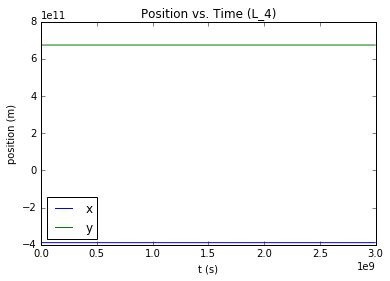

Max drift away from L_4 in x direction: 0.28125
Max drift away from L_4 in y direction: 0.185668945313


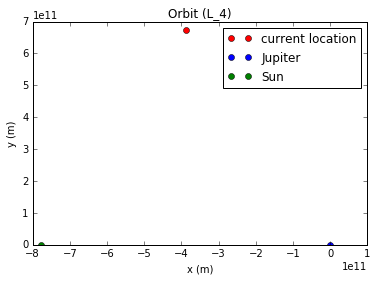

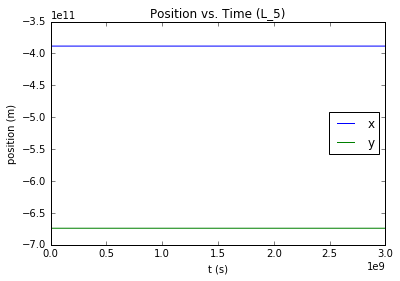

Max drift away from L_5 in x direction: 0.0
Max drift away from L_5 in y direction: 14.8737792969


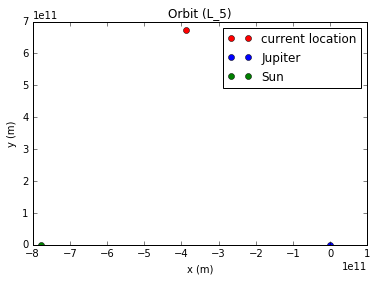

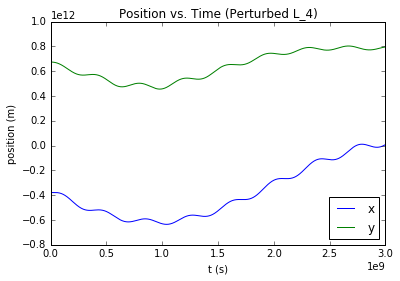

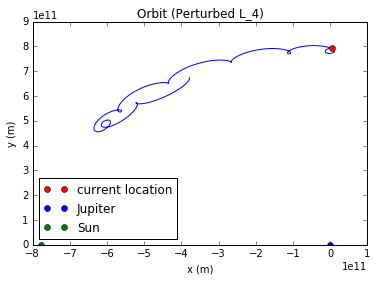

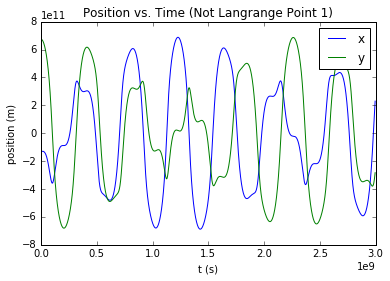

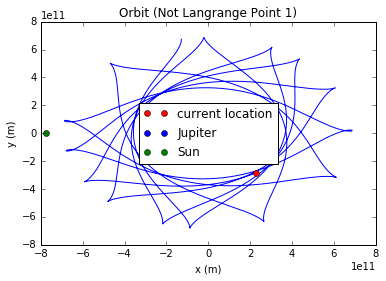

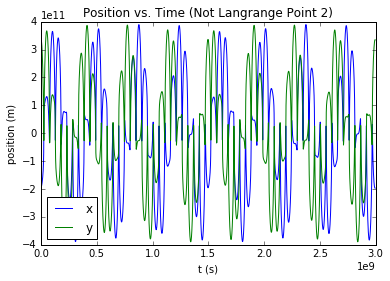

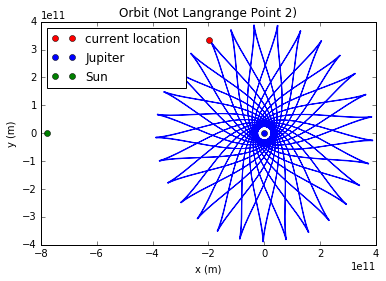

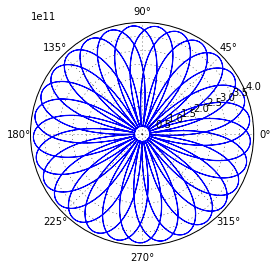

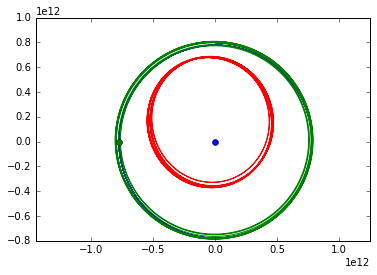

In [19]:
def rotating_to_inertial_frame(x, y, T, omega):
    '''Transforms x and y arrays of data in a rotating frame to the non-
    rotating frame'''
    
    x_inertial = x*np.cos(omega*T) - y*np.sin(omega*T)
    y_inertial = x*np.sin(omega*T) + y*np.cos(omega*T)
    return x_inertial, y_inertial

# Constants. @TODO: add units
G = 6.6742e-11
M_1 = 1.989e30
M_2 = 1.899e27
R = 778.3e9
T_J = 3.743e8
omega = np.sqrt(G*(M_1 + M_2) / R**3)

# Fixed position of the sun and Jupiter
x1, y1 =  M_2*R / (M_1 + M_2), 0
x2, y2 = -M_1*R / (M_1 + M_2), 0

alpha = np.pi/3
x0 = R*(M_2 - M_1)/(M_1 + M_2) * np.cos(alpha)
y0 = R*np.sin(alpha)

def x_acceleration6(x, x1, x2, y, y1, y2, v_y, inertial_frame=False):
    r1 = np.sqrt((x-x1)**2 + (y-y1)**2)
    r2 = np.sqrt((x-x2)**2 + (y-y2)**2)
    
    F_gravity = -G*M_1/r1**3 * (x-x1) - G*M_2/r2**3 * (x-x2)
    
    if inertial_frame:
        return F_gravity
    
    F_coriolis = 2*omega*v_y
    F_centrifugal = omega**2 * x
    
    net_force = F_gravity + F_coriolis + F_centrifugal
    
    return net_force

def y_acceleration6(x, x1, x2, y, y1, y2, v_x, inertial_frame=False):
    r1 = np.sqrt((x-x1)**2 + (y-y1)**2)
    r2 = np.sqrt((x-x2)**2 + (y-y2)**2)
    
    F_gravity = -G*M_1/r1**3 * (y-y1) - G*M_2/r2**3 * (y-y2)
    
    if inertial_frame:
        return F_gravity
    
    F_coriolis = -2*omega*v_x
    F_centrifugal = omega**2 * y
    
    net_force = F_gravity + F_coriolis + F_centrifugal
    
    return net_force

def f6(r, t):
    x, y, v_x, v_y = r[0], r[1], r[2], r[3]
    a_x = x_acceleration6(x, x1, x2, y, y1, y2, v_y)
    a_y = y_acceleration6(x, x1, x2, y, y1, y2, v_x)
    return np.array([v_x, v_y, a_x, a_y])

def plot_rotating_frame(check=False):
    T = np.linspace(0, 8*T_J, 10000)
    
    # Langrange point L_4
    r  = np.array([x0,  y0, 0, 0])
    # Langrange point L_5
    r1 = np.array([x0, -y0, 0, 0])
    # Slightly perturbed Lagrange point
    r2 = np.array([x0+1e10, y0, 0, 0])
    # Not Langrange points
    r3 = np.array([x0/3, y0, 0, 0])
    r4 = np.array([x0/2, y0/2, 0, 0])
    
    data  = odeint(f6,  r, T)
    data1 = odeint(f6, r1, T)
    data2 = odeint(f6, r2, T)
    data3 = odeint(f6, r3, T)
    data4 = odeint(f6, r4, T)
    X,   Y,  VX,  VY =  data[:,0],  data[:,1],  data[:,2],  data[:,3]
    X1, Y1, VX1, VY1 = data1[:,0], data1[:,1], data1[:,2], data1[:,3]
    X2, Y2, VX2, VY2 = data2[:,0], data2[:,1], data2[:,2], data2[:,3]
    X3, Y3, VX3, VY3 = data3[:,0], data3[:,1], data3[:,2], data3[:,3]
    X4, Y4, VX4, VY4 = data4[:,0], data4[:,1], data4[:,2], data4[:,3]
    
    print('PLOTS FOR TROJAN ASTEROIDS IN ROTATING FRAME:')
    
    # For L_4
    plt.plot(T, X, label='x')
    plt.plot(T, Y, label='y')
    plt.title('Position vs. Time (L_4)')
    plt.xlabel('t (s)')
    plt.ylabel('position (m)')
    plt.legend(loc='best')
    plt.show()
    
    print('Max drift away from L_4 in x direction:', max(X) - X[0])
    print('Max drift away from L_4 in y direction:', max(Y) - Y[0])
    plt.plot(X, Y)
    plt.plot(X[-1], Y[-1], 'ro', label='current location')
    plt.title('Orbit (L_4)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.plot(x1, y1, 'bo', label='Jupiter')
    plt.plot(x2, y2, 'go', label='Sun')
    plt.legend(loc='best')
    plt.show()
    
    # For L_5
    plt.plot(T, X1, label='x')
    plt.plot(T, Y1, label='y')
    plt.title('Position vs. Time (L_5)')
    plt.xlabel('t (s)')
    plt.ylabel('position (m)')
    plt.legend(loc='best')
    plt.show()

    print('Max drift away from L_5 in x direction:', max(X1) - X1[0])
    print('Max drift away from L_5 in y direction:', max(Y1) - Y1[0])
    plt.plot(X1, -Y1)
    plt.plot(X[-1], Y[-1], 'ro', label='current location')
    plt.title('Orbit (L_5)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.plot(x1, y1, 'bo', label='Jupiter')
    plt.plot(x2, y2, 'go', label='Sun')
    plt.legend(loc='best')
    plt.show()
    
    # For point slightly perturbed from Langrange point
    plt.plot(T, X2, label='x')
    plt.plot(T, Y2, label='y')
    plt.title('Position vs. Time (Perturbed L_4)')
    plt.xlabel('t (s)')
    plt.ylabel('position (m)')
    plt.legend(loc='best')
    plt.show()
    
    plt.plot(X2, Y2)
    plt.plot(X2[-1], Y2[-1], 'ro', label='current location')
    plt.title('Orbit (Perturbed L_4)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.plot(x1, y1, 'bo', label='Jupiter')
    plt.plot(x2, y2, 'go', label='Sun')
    plt.legend(loc='best')
    plt.show()
    
    # For non-Lagrange point
    plt.plot(T, X3, label='x')
    plt.plot(T, Y3, label='y')
    plt.title('Position vs. Time (Not Langrange Point 1)')
    plt.xlabel('t (s)')
    plt.ylabel('position (m)')
    plt.legend(loc='best')
    plt.show()
    
    plt.plot(X3, Y3)
    plt.plot(X3[-1], Y3[-1], 'ro', label='current location')
    plt.title('Orbit (Not Langrange Point 1)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.plot(x1, y1, 'bo', label='Jupiter')
    plt.plot(x2, y2, 'go', label='Sun')
    plt.legend(loc='best')
    plt.show()
    
    # For another non-Lagrange point
    plt.plot(T, X4, label='x')
    plt.plot(T, Y4, label='y')
    plt.title('Position vs. Time (Not Langrange Point 2)')
    plt.xlabel('t (s)')
    plt.ylabel('position (m)')
    plt.legend(loc='best')
    plt.show()
    
    plt.plot(X4, Y4)
    plt.plot(X4[-1], Y4[-1], 'ro', label='current location')
    plt.title('Orbit (Not Langrange Point 2)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.plot(x1, y1, 'bo', label='Jupiter')
    plt.plot(x2, y2, 'go', label='Sun')
    plt.legend(loc='best')
    plt.show()
    
    # Just a self-check, making sure I got the initial values right.
    if check:
        plt.plot(x0,y0, 'ro')
        plt.plot(x1,y1, 'bo')
        plt.plot(x2,y2, 'go')
        plt.title('Initial Positions')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        plt.show()
        
    r0 = np.sqrt(X4**2 + Y4**2)
    theta = np.empty(len(r0))
    for i in range(len(r0)):
        theta[i] = np.arctan2(Y[i], X[i])
    theta += omega*T
    plt.subplot(111, polar=True)
    plt.plot(theta, r0)
    plt.show()
    
    X_I,  Y_I = rotating_to_inertial_frame( X,  Y, omega, T)
    X1_I, Y1_I = rotating_to_inertial_frame(X1, Y1, omega, T)
    X2_I, Y2_I = rotating_to_inertial_frame(X2, Y2, omega, T)
    X3_I, Y3_I = rotating_to_inertial_frame(X3, Y3, omega, T)
    X4_I, Y4_I = rotating_to_inertial_frame(X4, Y4, omega, T)
    
    plt.plot(X1_I, Y1_I)
    plt.plot(X2_I, Y2_I)
    plt.plot(X3_I, Y3_I)
    plt.plot(x1, y1, 'bo', label='Jupiter')
    plt.plot(x2, y2, 'go', label='Sun')
    plt.axis('equal')
        
        
plot_rotating_frame()

I slightly perturbed the x coordinate for the $L_4$ point, and the orbit changed rather dramatically. It does not stay within the general vicinity of the Lagrange point.

The range of possible alphas that stay (roughly) at the Lagrange point is extremely small. I added 0.1 to the angle and the asteroid oscillated back and forth around the Langrage point in weird orbits. When I added 0.01, there was still a noticeable deviation from the Lagrange point, but it was significantly smaller. So, when alpha is within +/- 0.01 radians of the Lagrange point, the orbit is stable. 

In the rotating frame, the sun and Jupiter are at rest. Since we put the asteroids at a Lagrange point, they will orbit the sun with the same period as Jupiter...and therefore they too will be at rest in this frame. That's why the plot for position vs. time is simply a horizontal line for both x and y. If you put the asteroid at some place that isn't a Lagrange point, it just wanders around Jupiter in a cool orbit.

In the orbit plots for the Langrange points, it just looks like I just plotted three dots, but that's just because the asteroid is barely moving in the rotating frame!

